<a href="https://colab.research.google.com/github/kyashhh/ETH-Price-Pridiction/blob/main/ETH_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementation of RNN/LSTM**

In [ ]:
#Initiating the Yahoo Finance API
!pip install yfinance

     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 6.4 MB 11.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# Importing libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

[*********************100%***********************]  1 of 1 completed


The head of the dataframe of BTC: 


                    Open          High           Low         Close  \
Date                                                                 
2016-01-01  28513.429688  28864.216797  28273.705078  28763.769531   
2016-01-02  28782.841797  28878.207031  28600.589844  28704.431641   
2016-01-03  28713.703125  28724.630859  28096.636719  28467.287109   
2016-01-04  28470.597656  28897.769531  28404.460938  28842.994141   
2016-01-05  28841.529297  28875.925781  28606.195312  28734.496094   

               Adj Close      Volume  
Date                                  
2016-01-01  28763.769531  2402570153  
2016-01-02  28704.431641  1993147335  
2016-01-03  28467.287109  2623809084  
2016-01-04  28842.994141  2562524545  
2016-01-05  28734.496094  2296484779  


 Description of the dataset of BTC: 


               Open          High           Low         Close     Adj Close  \
count  2

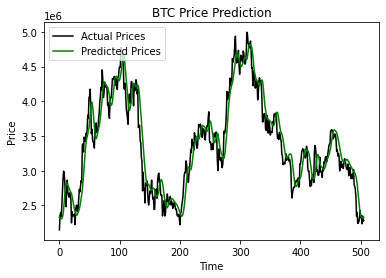

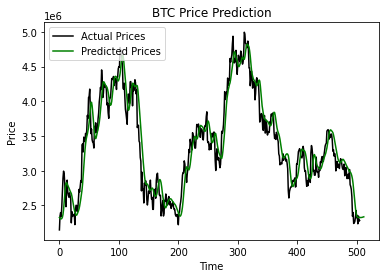

[*********************100%***********************]  1 of 1 completed


The head of the dataframe of ETH: 


                    Open          High           Low         Close  \
Date                                                                 
2017-11-11  19455.863281  20815.558594  19430.189453  20504.613281   
2017-11-12  20505.201172  20796.009766  19451.107422  20063.285156   
2017-11-13  20005.748047  21399.521484  20005.748047  20722.728516   
2017-11-14  20725.802734  22287.546875  20725.802734  22081.068359   
2017-11-15  22102.845703  22277.746094  21523.595703  21754.876953   

               Adj Close        Volume  
Date                                    
2017-11-11  20504.613281   54884332639  
2017-11-12  20063.285156  105134352629  
2017-11-13  20722.728516   68170861653  
2017-11-14  22081.068359   69957072000  
2017-11-15  21754.876953   47161182116  


 Description of the dataset of ETH: 


                Open           High            Low          Close  \
coun

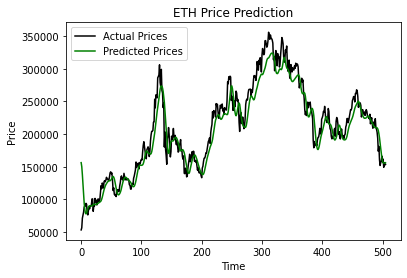

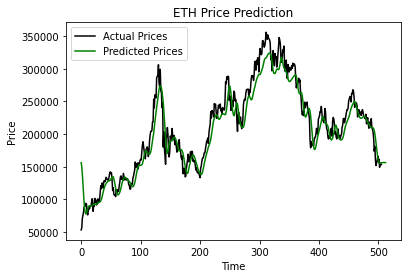

In [ ]:
# The crypto currencies we will study
crypto_currency1 = 'BTC'
crypto_currency2 = 'ETH'

# The currency we will look at the cyptocurrency against
against_currency = 'INR'

# Defining a function for creating model
def create_model(x_train, y_train):
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))

  model.compile(optimizer='adam', loss='mean_squared_error')
  model.fit(x_train, y_train, epochs=25, batch_size=32)

  return model

# Defining a function for prediction
def prediction_function(crypto_currency):
  # The dataset should be read/downloaded from the 1st of Jan, 2016
  start_date = dt.datetime(2016, 1, 1)
  # The dateset should be read/download till today
  end_date = dt.datetime.now()

  df = yf.download(f'{crypto_currency}-{against_currency}', start=start_date, end=end_date)

  # Printing the first few entries of the dataset
  print("\n\nThe head of the dataframe of {}: \n\n".format(crypto_currency))
  print(df.head())

  print("\n\n Description of the dataset of {}: \n\n".format(crypto_currency))
  print(df.describe())

  # Pre-Processing

  # Scaling the data using the Min Max Scaling between 0 and 1
  scaler = MinMaxScaler(feature_range=(0, 1))

  df_scaled = scaler.fit_transform(df[['Close', 'Volume']].values.reshape(-1, 2))

  # Looks back on 60 days of data to predict the values of 61st day
  lookback = 60


  x_train, y_train, vol, = [], [], []

  # Filling up the x_train and y_train with the scaled data
  for i in range(lookback, len(df_scaled)):
      
      # Finding the consolidated Volume for the past lookback days
      com_vol = 0
      for j in range(i - lookback, i):
          com_vol += df_scaled[j, 1]
      
      # Re-Scaling it to the range [0, 1]
      com_vol = com_vol / 60
      vol.append(com_vol)
      
      # The value f Closing Price for the last 'lookback' days should be used to predict the value of today, hence all Closing Price from i - lookback to i (excluded) are the features
      x_train.append(df_scaled[i - lookback: i, 0])
      
      # The value of Closing price at i is the the required output/label
      y_train.append(df_scaled[i, 0])
      
      
  # Converting the data set we have created into a numpy array
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  vol = np.array(vol)

  # Adding the consolidated volume to the training data
  #x_train = np.column_stack((x_train, vol))

  print("\n\n The number of samples in our training data = " + str(len(x_train)) + "\n\n")

    # *********************** Testing Data **************************

  # Start Date of Testing data
  test_start = dt.datetime(2021, 1, 1)
  # End Date of Testing data
  test_end = dt.datetime.now()


  # Downloading the data from Yahoo Finance API
  df_test = yf.download(f'{crypto_currency}-{against_currency}', start=test_start, end=test_end)

  actual_prices = df_test['Close'].values

  # Creating a combined (Test + Train data set)
  df_total = pd.concat((df['Close'], df_test['Close']), axis=0)


  # The inputs to the model for testing will be the test data set - lookback days (as we don't have past data for the last 'lookback' days)
  model_inputs = df_total[len(df_total) - len(df_test) - lookback:].values
  model_inputs = model_inputs.reshape(-1, 1)
  # The test data has not been scaled, so scaling the test data to the range (0, 1) using the MinMaxScaler
  model_inputs = scaler.fit_transform(model_inputs)


  x_test = []

  # Creating an 2D array of of our data where each data item has 'lookback' number of rows signifying the Closing Price of past 'lookback' days 
  for i in range(lookback, len(model_inputs)):
      x_test.append(model_inputs[i - lookback: i, 0])

  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

  print("\n\n The number of samples in our training data = " + str(len(x_test)) + "\n\n")
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  # Creating the model
  model = create_model(x_train, y_train)

  # Predicting the value and inverting the scaling
  prediction_prices = model.predict(x_test)
  prediction_prices = scaler.inverse_transform(prediction_prices)

  # Plotting the training, test and prediction data
  plt.plot(actual_prices, color='black', label='Actual Prices')
  plt.plot(prediction_prices, color='green', label='Predicted Prices')
  plt.title("{} Price Prediction".format(crypto_currency))
  plt.xlabel("Time")
  plt.ylabel("Price")
  plt.legend(loc='upper left')
  plt.show()

  # Predict next day

  real_data = [model_inputs[len(model_inputs) - lookback:len(model_inputs) + 1, 0]]
  real_data = np.array(real_data)

  prediction = []
  #real_data[0].shape

  for i in range(7):
      rd = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
      t = model.predict(rd)
      price = scaler.inverse_transform(t)
      prediction.append(price[0][0])
      n_real_data = []
      for i in range(1, len(real_data[0])):
          n_real_data.append([real_data[0][i]])
      n_real_data.append(t[0])
      n_real_data = np.array(n_real_data) 
      n_real_data = np.transpose(n_real_data)
      real_data = n_real_data
      
  # Prediction
  prediction = np.array(prediction)
  prediction = np.reshape(prediction, (len(prediction), 1))

  final_prediction_prices = prediction_prices
  final_prediction_prices = np.row_stack((final_prediction_prices, prediction))

  plt.plot(actual_prices, color='black', label='Actual Prices')
  plt.plot(final_prediction_prices, color='green', label='Predicted Prices')
  plt.title("{} Price Prediction".format(crypto_currency))
  plt.xlabel("Time")
  plt.ylabel("Price")
  plt.legend(loc='upper left')
  plt.show()

  price_today = actual_prices[len(actual_prices)-1]
  pred_price_today = prediction_prices[len(prediction_prices)-1][0]

  max_price = prediction[0][0]
  min_price = prediction[0][0]
  for i in range(len(prediction)):
    max_price = max(max_price, prediction[i][0])
    min_price = min(min_price, prediction[i][0])

  upside = (((max_price - pred_price_today)*100)/pred_price_today)
  downside = (((min_price - pred_price_today)*100)/pred_price_today)
  
  return [upside, downside]

#Initializing the function for both, ETH and BTC
sides1 = prediction_function(crypto_currency1)
sides2 = prediction_function(crypto_currency2)

In [ ]:
amount = np.float64(input("Enter the amount: "))

if sides1[0] < 0:
  sides1[0] = 0

if sides2[0] < 0:
  sides2[0] = 0

if sides1[0] == 0 and sides2[0] == 0:
  print("This is not the right time to invest! All the cryptocurrencies are going in loss. You might suffer a low of (upper limit): {}% !!!".format(sides1[1] + sides2[1]))

else:
  BTC_share = amount*(sides1[0]/(sides1[0] + sides2[0]))
  BTC_upside = (BTC_share*sides1[0])/100
  BTC_downside = (BTC_share*sides1[1])/100

  ETH_share = amount*(sides2[0]/(sides1[0] + sides2[0]))
  ETH_upside = (ETH_share*sides2[0])/100
  ETH_downside = (ETH_share*sides2[1])/100

  total_upside = BTC_upside + ETH_upside
  total_downside = BTC_downside + ETH_downside

  print("You must invest {} {} in {}, and {} {} in {}. \n For an upside of {} {}% and a downside of {} {}% !".format(
                                                                        against_currency, BTC_share, crypto_currency1, 
                                                                        against_currency, ETH_share, crypto_currency2,
                                                                        against_currency, (total_upside/amount) * 100,
                                                                        against_currency, (total_downside/amount) * 100))

Enter the amount: 50000
You must invest INR 33045.41147998851 in BTC, and INR 16954.588520011494 in ETH. 
 For an upside of INR 0.3188204092048374% and a downside of INR -0.033834730713435235% !
